In [1]:
import numpy as np
import sys
import time
import h5py as h5
import matplotlib.pyplot as plt

sys.path.append(r"C:\Users\haoyuan\Documents\GitHub\CrystalDiff")

from CrystalDiff import util, pulse, lclsutil, crystal, lightpath

# Get the Crystal Geometries

In [2]:
# ----------------------------------------------------------------------------------------------------------
#                       Step 1: Pulse
# ----------------------------------------------------------------------------------------------------------
energy_center = 10.
pre_length = 1e6

# Set up the pulse
my_pulse = pulse.GaussianPulse3D()
my_pulse.set_pulse_properties(central_energy=energy_center,
                              polar=[0., 1., 0.],
                              sigma_x=708.2581446128465,
                              sigma_y=708.2581446128465,
                              sigma_z=1.,
                              x0=np.array([0., 0., -pre_length]))

# ----------------------------------------------------------------------------------------------------------
#                       Step 2: Split
# ----------------------------------------------------------------------------------------------------------
dtheta = np.arctan(1.5 * 1e-3 / 5.)  # This is the deviation angle.
half_period = util.get_grating_period(dtheta=dtheta,
                                      klen_in=my_pulse.klen0) / 2

grating_list = [crystal.RectangleGrating(), crystal.RectangleGrating()]
grating_list[0].set_a(half_period)
grating_list[0].set_b(half_period)
grating_list[1].set_a(half_period)
grating_list[1].set_b(half_period)

# ----------------------------------------------------------------------------------------------------------
#                       Step 3: Delay Lines
# ----------------------------------------------------------------------------------------------------------
# Some meta data for the delay line.
h_length = 2. * np.pi / (1.9201 * 1e-4)

# Some crystal properties
chi0 = complex(-0.97631E-05, 0.14871E-06)
chih_sigma = complex(0.59310E-05, -0.14320E-06)
chihbar_sigma = complex(0.59310E-05, -0.14320E-06)
chih_pi = complex(0.46945E-05, -0.11201E-06)
chihbar_pi = complex(0.46945E-05, -0.11201E-06)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                       Crystal for branch  1
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up the angles
angle_offset_1 = dtheta

# Bragg angle
bragg = np.radians(18.836) + 13e-6
miscut = np.deg2rad(10.)

# Get crystal angles
eta_b1 = np.zeros(6, dtype=np.float64)
theta_b1 = np.array([np.pi / 2. + bragg,
                     3 * np.pi / 2. + bragg,
                     3 * np.pi / 2. - bragg,
                     np.pi / 2. - bragg,
                     3 * np.pi / 2. - bragg,
                     np.pi / 2. - bragg])
rho_b1 = theta_b1 + np.pi
tau_b1 = np.array([0, miscut, miscut, 0,
                   -2 * miscut, 0 ])

# Add the effect of the global rotation due to the grating momentum transfer
theta_b1 += angle_offset_1
rho_b1 += angle_offset_1

# Initialize the crystals
crystal_list_1 = lclsutil.get_crystal_list(num=6,
                                           hlen=np.array([h_length, ] * 6),
                                           theta=theta_b1,
                                           eta=eta_b1,
                                           rho=rho_b1,
                                           tau=tau_b1,
                                           chi0=chi0,
                                           chih_sigma=chih_sigma,
                                           chihbar_sigma=chihbar_sigma,
                                           chih_pi=chih_pi,
                                           chihbar_pi=chihbar_pi)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                       Crystal for branch  2
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up the angles
angle_offset_2 = - dtheta
bragg = np.radians(18.836) + 13e-6

# Get crystal angles
eta_b2 = np.zeros(4, dtype=np.float64)
theta_b2 = np.array([3 * np.pi / 2. - bragg,
                     np.pi / 2. - bragg,
                     np.pi / 2. + bragg,
                     3 * np.pi / 2. + bragg])
rho_b2 = theta_b2 + np.pi
tau_b2 = np.zeros(4, dtype=np.float64)

# Add the effect of the global rotation due to the grating momentum transfer
theta_b2 += angle_offset_2
rho_b2 += angle_offset_2

# Initialize the crystals
crystal_list_2 = lclsutil.get_crystal_list(num=4,
                                           hlen=np.array([h_length, ] * 4),
                                           theta=theta_b2,
                                           eta=eta_b2,
                                           rho=rho_b2,
                                           tau=tau_b2,
                                           chi0=chi0,
                                           chih_sigma=chih_sigma,
                                           chihbar_sigma=chihbar_sigma,
                                           chih_pi=chih_pi,
                                           chihbar_pi=chihbar_pi)

# ------------------------------------------------------
#   Define the positions
# ------------------------------------------------------
path_list_fix = [5e6, 1e5, 2e5, 1.05e5, 6e6, 1e6]
path_list_var = [5e6- 2e5, 1e5, 4e5, 2e4, 3e5, 8.5e4, 6e6, 1e6]
delay_time = 100

# Arrange the crystals

In [3]:
# ---------------------------------------------------------------------------
#                  Adjust the position of the crystals
# ---------------------------------------------------------------------------

(fix_branch_path,
 kout_fixed,
 intersect_fixed,
 var_branch_path,
 kout_var,
 intersect_var) = lightpath.adjust_path_length(delay_time=delay_time,
                                               fix_branch_path=path_list_fix,
                                               fix_branch_crystal=crystal_list_2,
                                               var_branch_path=path_list_var,
                                               var_branch_crystal=crystal_list_1,
                                               grating_pair=grating_list,
                                               kin=my_pulse.k0)

# -----------------------------------------------------------------------------
#                 Update the crystals
# -----------------------------------------------------------------------------
crystal_list_1 = lclsutil.update_crystal_list(crystal_list_1,
                                              surface_points=np.copy(intersect_var[1:-2]))
crystal_list_2 = lclsutil.update_crystal_list(crystal_list_2,
                                              surface_points=np.copy(intersect_fixed[1:-2]))
grating_list[0].set_surface_point(np.copy(intersect_fixed[0]))
grating_list[1].set_surface_point(np.copy(intersect_fixed[-2]))

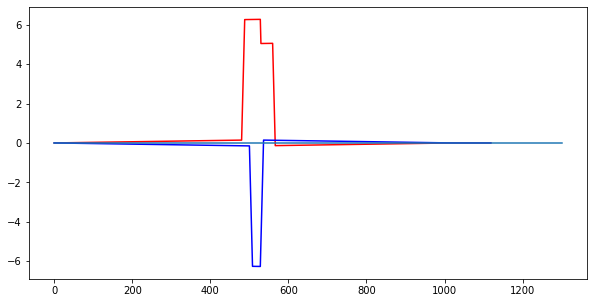

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

axes.plot(intersect_var[:,2]/1e4, intersect_var[:,1]/1e4,'r')
axes.plot(intersect_fixed[:,2]/1e4, intersect_fixed[:,1]/1e4,'b')

axes.plot([0, 1300], [0,0])
#axes.set_xlim([5e2-70, 5e2 + 150])
#axes.set_ylim([-50, 50])
#axes.set_aspect('equal', 'datalim')

plt.show()

# Generate a set of points to propagate

In [5]:
def get_point_with_specified_path(init_point, total_path, crystal_list, klist):
    """
    Calculate the intersection points given the initial point and the crystals.

    Notice that this function has a low efficiency. However, at present,
    I do not think I need a high efficiency version.

    :param klist:
    :param init_point:
    :param total_path:
    :param crystal_list:
    :return:
    """
    # Get the reflection number
    reflect_num = len(crystal_list)

    # Create holders
    trace = [np.copy(init_point), ]

    # Copy the variables to avoid potential modification
    s = np.copy(init_point)
    path_remain = np.copy(total_path)

    # Loop through all the reflections
    for idx in range(reflect_num):
        # Get the intersection point
        new_point = util.get_intersection_point(s=s,
                                                k=klist[idx],
                                                n=crystal_list[idx].normal,
                                                x0=crystal_list[idx].surface_point)
        # Calculate the remaining path length.
        path_section = util.l2_norm(new_point - trace[-1])

        if path_remain - path_section <= 0:
            # If this remaining path length is negative, it means that the propagation should stop
            # before this intersection.

            new_point = trace[-1] + path_remain * (klist[idx] / util.l2_norm(klist[idx]))
            trace.append(new_point)
            return trace

        else:
            # If the remaining path length is positive, it means that the intersection
            # indeed happens.

            # Update the path length change
            path_remain -= path_section

            # Record the new point
            trace.append(new_point)

            # Update the k and s value
            s = np.copy(trace[-1])
            
    return trace

In [6]:
total_path = sum(var_branch_path) + pre_length

# Prepare all the crystals
crystal_all = [grating_list[0],] + crystal_list_1 + [grating_list[1],]

# Prepare the incident points
pnum = 300 # number of points to propagate
init_points = np.zeros((pnum, 3), dtype=np.float64)

# Holder for the final and all points.
final_points = np.zeros((pnum, 3), dtype=np.float64)
all_points = []

for idx in range(pnum):
    init_points[idx, 0] = np.cos( 2 * np.pi * idx / pnum )
    init_points[idx, 1] = np.sin( 2 * np.pi * idx / pnum )
    init_points[idx, 2] = - pre_length
    
# For each point, calculate the point after the propogation
for idx in range(pnum):
    points = get_point_with_specified_path(init_point = init_points[idx],
                                           total_path = total_path,
                                           crystal_list = crystal_all, 
                                           klist = kout_var)
    all_points.append(np.copy(points))
    final_points[idx, :] = points[-1]
    
inter_points = np.stack((x[3] for x in all_points))

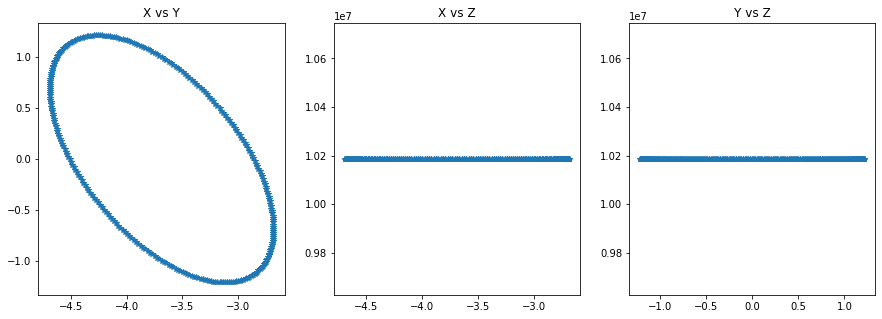

In [7]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,5))

axes[0].plot(final_points[:, 0], final_points[:, 1], '*')
axes[0].set_title("X vs Y")

axes[1].plot(final_points[:, 0], final_points[:, 2], "*")
axes[1].set_title("X vs Z")

axes[2].plot(final_points[:, 1], final_points[:, 2], "*")
axes[2].set_title("Y vs Z")


plt.show()

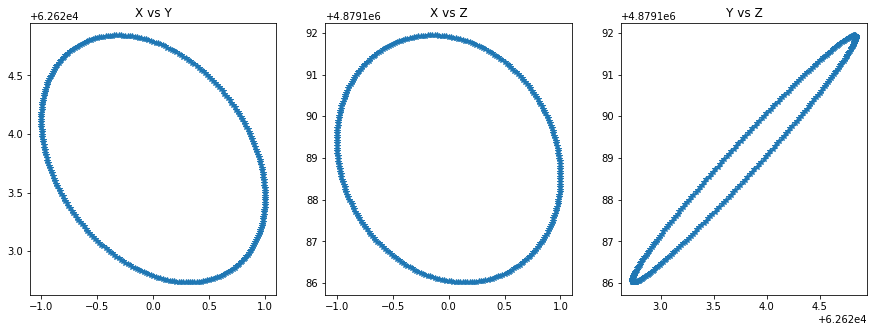

In [8]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,5))

axes[0].plot(inter_points[:, 0], inter_points[:, 1],'*')
axes[0].set_title("X vs Y")

axes[1].plot(inter_points[:, 0], inter_points[:, 2],'*')
axes[1].set_title("X vs Z")

axes[2].plot(inter_points[:, 1], inter_points[:, 2],'*')
axes[2].set_title("Y vs Z")


plt.show()